# Andres Graterol - 4031393 - Fall 22
# Homework 5

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Problem 1

In [15]:
# Initialize the weights 
number_of_classes_M = 2 
number_of_features_F = 5
# W is of size M x F (Each class (M) has 5 classes (F))

# Initialize the weights from a uniform pdf with bounds [-1, 1]
initial_weights = np.random.uniform(low=-1, high=1, 
                                   size=(number_of_classes_M, number_of_features_F))

In [29]:
# TODO: Generate the data in another manner (based on labels first)
# ... to see if we get a stronger accuracy 
# If not try for other epochs or using other learning rates
# Also comment out all print statements

#print(initial_weights)

# Number of data points 
N = 1000
points_per_class = math.floor(N/2)

# 1000 total training data points, 500 for each class
training_data_points_class0 = np.random.normal(loc=0, scale=1, size=(points_per_class, number_of_features_F))
training_data_points_class1 = np.random.normal(loc=0.1, scale=1, size=(points_per_class, number_of_features_F))

# Combine the two classes into one array 
training_data_points_old = np.concatenate((training_data_points_class0, training_data_points_class1))

# Make sure we keep track of indices to map the labels to
enum = list(enumerate(training_data_points_old))
random.shuffle(enum)
indices, training_data_points = zip(*enum)

training_data_points = np.array(training_data_points)

# Making sure that the shuffling has worked correctly 
print(training_data_points[0])
print(training_data_points_old[indices[0]])

labels_class0 = []
labels_class1 = []

# Create one-hot encoding formatting
for i in range(points_per_class):
    labels_class0.append([1, 0])
    labels_class1.append([0, 1])

labels_class0 = np.array(labels_class0)
labels_class1 = np.array(labels_class1)

# Labels array will be of size (N, 2)
labels = np.concatenate((labels_class0, labels_class1))

#print(labels_class0)
#print(labels_class1)

lr = 0.00005 
# Actually means 50 epochs (go through every 1000 points 50 times)
# We get a 1000 new weights every iteration
iterations = 50

[-0.93976513  0.10589197  0.0881246   0.88010835  0.3545333 ]
[-0.93976513  0.10589197  0.0881246   0.88010835  0.3545333 ]


In [41]:
# Function to compute gradient matrix for each point
def compute_gradient_matrix(point, label, output, number_of_classes, number_of_features):
    matrix = np.zeros((number_of_classes, number_of_features))

    for k in range(number_of_classes):
        for i in range(number_of_features):
            gradient = (output[k]-label[k])*point[i]
            matrix[k, i] = gradient

    return matrix

# Function to add individual point's gradient matrices together per iteration
def update_gradient_matrix(matrix1, matrix2):
    final_matrix = np.zeros((2, 5))

    for k in range(2):
        for i in range(5):
            final_matrix[k, i] = matrix1[k, i] + matrix2[k, i]

    return final_matrix

def map_to_class(prediction):
    if (prediction[0] > prediction[1]):
        # One-hot encoding for class 0
        prediction = [1, 0]
    else:
        # One-hot encoding for class 1
        prediction = [0, 1]
    
    return prediction

def compute_accuracy(prediction, label):    
    if (prediction[0] == label[0]):
        return 1

    return 0

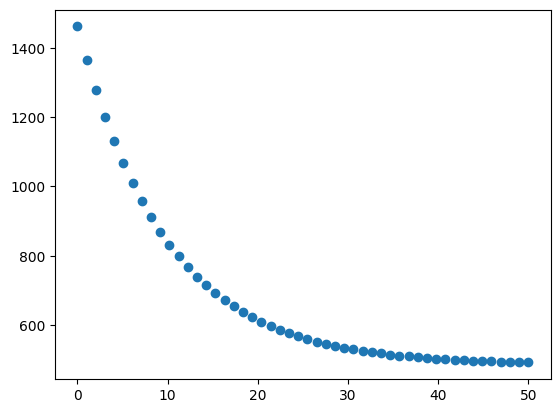

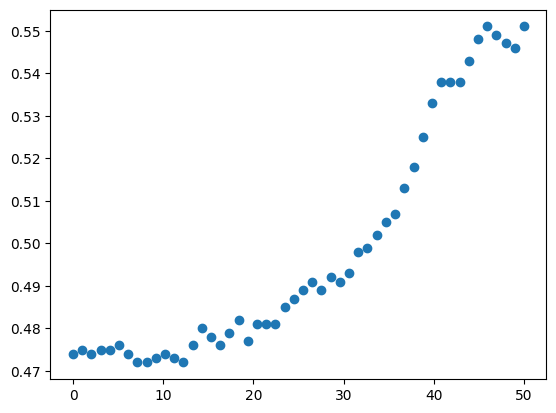

In [43]:
# Expecting 50 items in each of these 
accuracy_list = []
error_list = []
for i in range(iterations):
    
    # initialize a new gradient matrix to use for every iteration    
    gradient_matrix = np.zeros((number_of_classes_M, number_of_features_F))    
    iteration_error = 0
    correct_predictions = 0
    # Go through the 1000 data points every epoch
    for j in range(N):

        # If we are in the very first iteration, use the initial weights
        if (i == 0):
            # For some opbservation vector, x, of size F (number of features)
            # output is given by y(x) = Wx = (y1(x), y2(x))^T
            # Output is of size (2,) -> (2, 5) X (5,)

            # GET THE OUTPUT FOR EVERY DATA POINT
            output = np.matmul(initial_weights, training_data_points[j])
        else:
            output = np.matmul(updated_weights, training_data_points[j])

        # Compute classification accuracy
        prediction = map_to_class(output)
        correct_predictions += compute_accuracy(prediction, labels[indices[j]])

        #              (y1(x)     - tn1)^2
        error_class0 = (output[0] - labels[indices[j], 0])**2
        #              (y2(x)     - tn2)^2
        error_class1 = (output[1] - labels[indices[j], 1])**2   
        point_error = 0.5*error_class0 + 0.5*error_class1

        iteration_error += point_error   
        #error_list[i] = iteration_error

        # Now compute the gradient matrix for the point...
        point_matrix = compute_gradient_matrix(training_data_points[j], labels[indices[j]], output, number_of_classes_M, number_of_features_F)
        gradient_matrix = update_gradient_matrix(gradient_matrix, point_matrix)

    # Done with all the data points in an iteration
    accuracy = correct_predictions/N
    accuracy_list.append(accuracy)
    error_list.append(iteration_error)

    # New weights = weights from previous step - lr(gradients)
    if (i == 0):
        updated_weights = initial_weights - lr*(gradient_matrix)
    else:
        updated_weights = updated_weights - lr*(gradient_matrix)

#print(error_list)
x = np.linspace(0, iterations, 50)
plt.scatter(x, error_list)
plt.show()


plt.scatter(x, accuracy_list)
plt.show()

## Problem 2

In [42]:
class ReportErrorCallback(keras.callbacks.Callback):
    def __init__(self, x_train, y_train, x_test, y_test, training_error_list, testing_error_list):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.training_error_list = training_error_list
        self.testing_error_list = testing_error_list

    def on_epoch_end(self, epoch, logs=None):
        train_error_mse = self.model.evaluate(self.x_train, self.y_train)
        self.training_error_list.append(train_error_mse)
        test_error_mse = self.model.evaluate(self.x_test, self.y_test)
        self.testing_error_list.append(test_error_mse)

        if (epoch % 10 == 0):   
            print(f"Epoch #{epoch}:")
            print("MSE on training data = {} ; MSE of testing data = {}".format(train_error_mse, test_error_mse))

        

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 61.7748
Epoch #0:
MSE on training data = 65.52501678466797 ; MSE of testing data = 61.77477264404297
404/404 [==============================] - 1s 1ms/step - loss: 122.6930
Epoch 2/500
404/404 [==============================] - 0s 960us/step - loss: 65.6285
Epoch 3/500
404/404 [==============================] - 0s 1ms/step - loss: 65.3120
Epoch 4/500
404/404 [==============================] - 1s 1ms/step - loss: 62.6808
Epoch 5/500
404/404 [==============================] - 0s 1ms/step - loss: 60.4019
Epoch 6/500
404/404 [==============================] - 0s 933us/step - loss: 60.6368
Epoch 7/500
404/404 [==============================] - 0s 935us/step - loss: 59.5162
Epoch 8/500
404/404 [==============================] - 0s 952us/step - loss: 60.0572
Epoch 9/500
404/404 [==============================] - 0s 959us/step - loss: 57.5795
Epoch 10/500
404/404 [==============================] - 0s 951us/step - loss: 58.7

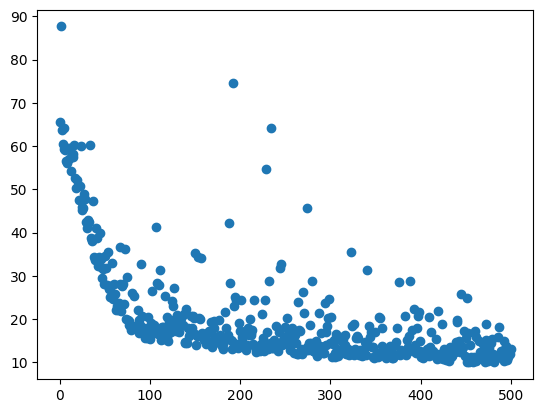

Testing Error per epoch


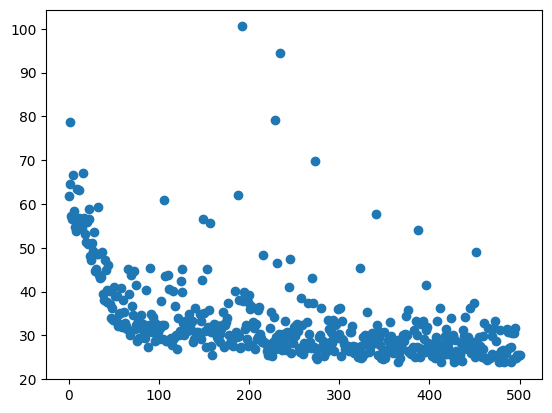

In [44]:
number_of_feature = 13
number_of_units_in_hidden_layer = 100
epochs = 500
#### load the BOSTON regression dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)
#### pre-process the data
x_train -= np.mean(x_train)
x_train /= np.std(x_train)
x_test -= np.mean(x_test)
x_test /= np.std(x_test)

NN_regression_model = tf.keras.Sequential()
hidden_layer_1 = tf.keras.layers.Dense(units=number_of_units_in_hidden_layer, activation='relu') # define layer
NN_regression_model.add(hidden_layer_1) # add layer
hidden_layer_2 = tf.keras.layers.Dense(units=number_of_units_in_hidden_layer,
    activation='relu') # define layer
NN_regression_model.add(hidden_layer_2) # add layer
output_layer = tf.keras.layers.Dense(units=1, activation=None) # define layer
    #(units = 1 for regression)
NN_regression_model.add(output_layer) # add layer
  
# Compile the model
NN_regression_model.compile(optimizer="Adam", loss="mse")
training_error_list = []
testing_error_list = []
NN_regression_model.fit(x_train, y_train, epochs=epochs, batch_size = 1, callbacks=[ReportErrorCallback(x_train, y_train, x_test, y_test, training_error_list, testing_error_list)])

# Plot the Training and Testing errors with respect to the epochs
x = np.linspace(0, epochs, epochs)
print("Training Error per epoch")
plt.scatter(x, training_error_list)
plt.show()
print("Testing Error per epoch")
plt.scatter(x, testing_error_list)
plt.show()


The two graphs above look very similar in their behaviors, and both errors look to be converging. The area of overfitting seems to be between epochs 100 and 300, as the training error plot seems to be smoother and less noisy than the testing error plot around this region. You can also see that the training error plot has a lower MSE around these epochs than the testing error plot. 

## Problem 3

In [61]:
number_of_features = 28*28
#### load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train,x_test=x_train.astype('float32'), x_test.astype('float32')

# normalize and vectorize the data
x_train /= 255
x_test /= 255
x_train, x_test= x_train.reshape(60000,784,1), x_test.reshape(10000,784,1)

# one-hot encoding (OHE)
y_train_OHE = []
for label in y_train:
    all_zero_temp = 10*[0]
    all_zero_temp[label] = 1.0
    y_train_OHE.append(all_zero_temp)

y_train_OHE = np.asarray(y_train_OHE)

y_test_OHE = []
for label in y_test:
    all_zero_temp = 10*[0]
    all_zero_temp[label] = 1.0
    y_test_OHE.append(all_zero_temp)
    
y_test_OHE = np.asarray(y_test_OHE)

# Now to create the model
NN_1layer_classification = tf.keras.Sequential()

# Define the hidden layer (100 units and Relu activation function)
hidden_layer = tf.keras.layers.Dense(units=100, activation='relu')
NN_1layer_classification.add(hidden_layer)

# define flatten layer (reshaping from tensor to vector)
flatten_layer = tf.keras.layers.Flatten()
NN_1layer_classification.add(flatten_layer) # add flatten layer

# Output of the network is a vector of length M (10)
output = tf.keras.layers.Dense(units=10, activation='softmax')
NN_1layer_classification.add(output)

# Compile the model
NN_1layer_classification.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# train using 100 epochs and batch size of 100
NN_1layer_classification.fit(x_train, y_train_OHE, epochs=100, batch_size=100)

# print training and testing accuracy
train_info = NN_1layer_classification.evaluate(x_train, y_train_OHE)
test_info = NN_1layer_classification.evaluate(x_test, y_test_OHE)
print(f"Training accuracy: {train_info[1]*100}% ; Testing accuracy: {test_info[1]*100}%")

Epoch 1/100
600/600 [==============================] - 28s 46ms/step - loss: 0.3643 - accuracy: 0.8972
Epoch 2/100
600/600 [==============================] - 27s 45ms/step - loss: 0.2885 - accuracy: 0.9195
Epoch 3/100
600/600 [==============================] - 32s 53ms/step - loss: 0.2753 - accuracy: 0.9226
Epoch 4/100
600/600 [==============================] - 28s 46ms/step - loss: 0.2706 - accuracy: 0.9236
Epoch 5/100
600/600 [==============================] - 27s 45ms/step - loss: 0.2659 - accuracy: 0.9256
Epoch 6/100
600/600 [==============================] - 27s 45ms/step - loss: 0.2633 - accuracy: 0.9260
Epoch 7/100
600/600 [==============================] - 27s 45ms/step - loss: 0.2587 - accuracy: 0.9277
Epoch 8/100
600/600 [==============================] - 27s 45ms/step - loss: 0.2556 - accuracy: 0.9286
Epoch 9/100
600/600 [==============================] - 27s 45ms/step - loss: 0.2545 - accuracy: 0.9293
Epoch 10/100
600/600 [==============================] - 27s 45ms/step - l

## Problem 4

In [60]:
number_of_features = 28*28
#### load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#### building the input vector from the 28x28 pixels
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalizing the data
x_train /= 255
x_test /= 255

# one-hot encoding (OHE)
y_train_OHE = []
for label in y_train:
    all_zero_temp = 10*[0]
    all_zero_temp[label] = 1.0
    y_train_OHE.append(all_zero_temp)

y_train_OHE = np.asarray(y_train_OHE)

y_test_OHE = []
for label in y_test:
    all_zero_temp = 10*[0]
    all_zero_temp[label] = 1.0
    y_test_OHE.append(all_zero_temp)

y_test_OHE = np.asarray(y_test_OHE)

#### Construct the NN classification model
NN_classification_model = tf.keras.Sequential()

# define conv layer
Conv2d_layer = tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1))
NN_classification_model.add(Conv2d_layer) # add layer

# define max pooling layer
MaxPool_layer = tf.keras.layers.MaxPool2D(pool_size=(4,4))
NN_classification_model.add(MaxPool_layer) # add layer7

# define flatten layer (reshaping from tensor to vector)
flatten_layer = tf.keras.layers.Flatten()
NN_classification_model.add(flatten_layer) # add flatten layer

# add two dense layers 
dense_layer_1 = tf.keras.layers.Dense(units=100, activation='relu')
NN_classification_model.add(dense_layer_1)
dense_layer_2 = tf.keras.layers.Dense(units=100, activation='relu')
NN_classification_model.add(dense_layer_2)

#NN_classification_model.summary()

# add output layer
output_layer = tf.keras.layers.Dense(units=10, activation='softmax')
NN_classification_model.add(output_layer)

# compile the model
NN_classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# train using 100 epochs and batch size of 100
NN_classification_model.fit(x_train, y_train_OHE, epochs=100, batch_size=100)

# print training and testing accuracy
train_info = NN_classification_model.evaluate(x_train, y_train_OHE)
test_info = NN_classification_model.evaluate(x_test, y_test_OHE)
print(f"Training accuracy: {train_info[1]*100}% ; Testing accuracy: {test_info[1]*100}%")

Epoch 1/100
600/600 [==============================] - 26s 42ms/step - loss: 0.5078 - accuracy: 0.8172
Epoch 2/100
600/600 [==============================] - 22s 37ms/step - loss: 0.3347 - accuracy: 0.8789
Epoch 3/100
600/600 [==============================] - 22s 37ms/step - loss: 0.2919 - accuracy: 0.8939
Epoch 4/100
600/600 [==============================] - 22s 37ms/step - loss: 0.2642 - accuracy: 0.9031
Epoch 5/100
600/600 [==============================] - 28s 46ms/step - loss: 0.2470 - accuracy: 0.9089
Epoch 6/100
600/600 [==============================] - 25s 42ms/step - loss: 0.2268 - accuracy: 0.9166
Epoch 7/100
600/600 [==============================] - 22s 37ms/step - loss: 0.2134 - accuracy: 0.9200
Epoch 8/100
600/600 [==============================] - 22s 37ms/step - loss: 0.1986 - accuracy: 0.9261
Epoch 9/100
600/600 [==============================] - 22s 37ms/step - loss: 0.1871 - accuracy: 0.9308
Epoch 10/100
600/600 [==============================] - 22s 37ms/step - l